In [1]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 81.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102744 sha256=78920b926b6878737e4337373e1dcc0b0e993189c6c4530c07dc8aca71773e04
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [2]:
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100355 sha256=56602758a8d73473e55c33713e994ad889f890743a4df04478c1d81fe0b80f43
  Stored in directory: /root/.cache/pip/wheels/3d/69/36/c8bd247900ab5ade980a418ac2faed41e08f5006f7c369282f
Successfully built eofs


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [4]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Utilis

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from eofs.xarray import Eof


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """
    n_eofs=5
    min_co2 = 0.
    max_co2 = 9500
    def normalize_co2(data):
       return data / max_co2

    def un_normalize_co2(data):
        return data * max_co2

    min_ch4 = 0.
    max_ch4 = 0.8
    def normalize_ch4(data):
       return data / max_ch4

    def un_normalize_ch4(data):
        return data * max_ch4
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)

    return X, length_all,(so2_solver, bc_solver),inputs


def prepare_predictand(data_sets,data_path,time_reindex=True):

    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y_all = []
    length_all = []

    for file in data_sets:

        data = xr.open_dataset(data_path + f"/outputs_{file}.nc")
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    inp = xr.concat([xr.open_dataset(data_path + f"/outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    inp["pr"] *= 86400
    inp["pr90"] *= 86400


    return Y, length_all,inp


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [6]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [7]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr,X_length,solver,X_inputs = prepare_predictor(train_files,train_path)
y_train_xr,y_train_length,y_train_inputs  = prepare_predictand(train_files,train_path)

#Testing set
X_test_xr, _ , solver, X_test_inputs = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ , y_test_inputs = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [8]:

#this is important for model to fit

y_train_df = y_train_xr["diurnal_temperature_range"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())


In [9]:

X_train_df = X_inputs
X_test_df = X_test_inputs
# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 12) (86, 12)


In [10]:
#var  = 'pr'
y_train = y_train_xr['diurnal_temperature_range'].data
y_test  = y_test_xr['diurnal_temperature_range'].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32")
y_test  = np.expand_dims(y_test, -1).astype("float32")

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)

(753, 96, 144, 1) (86, 96, 144, 1)


In [11]:

#this is important for model to fit

y_train_df = y_train_xr["diurnal_temperature_range"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())


Data standarization

In [12]:
# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()

In [13]:
# Standardize the predictand
y_train    = y_train_df.to_numpy().astype(np.float64)
train_dir_mean, train_dir_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_dir_mean) / train_dir_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 12) (753, 13824) (86, 12)


In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
svr = SVR(kernel="rbf")

# Create the MultiOutputRegressor with SVR
model = MultiOutputRegressor(svr)

# Fit the model
model.fit(X_train, y_train)

In [ ]:
# predict
standard_posterior_mean =  model.predict(X_test)
standard_posterior_var = model.predict(X_test)
posterior_mean   = standard_posterior_mean * train_dir_std + train_dir_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_dir_std
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                                 'latitude': X_test_xr.latitude.values,
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

<ipython-input-19-25d21cfd0c5d>:5: RuntimeWarning: invalid value encountered in sqrt
  posterior_std    = np.sqrt(standard_posterior_var) * train_pr_std


In [ ]:
standard_posterior_var = np.clip(standard_posterior_var, a_min=0.0, a_max=None)
posterior_std = np.sqrt(standard_posterior_var) * train_dir_std

In [ ]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.299856334689244
RMSE at 2100: 0.48735780058714573
RMSE 2045-2055: 0.36609664038686546
RMSE 2090-2100: 0.5297443990940557
RMSE 2050-2100: 0.46281345073777447
RMSE average last 20y: 0.4028885597546042


[Text(0.5, 1.0, 'Difference')]

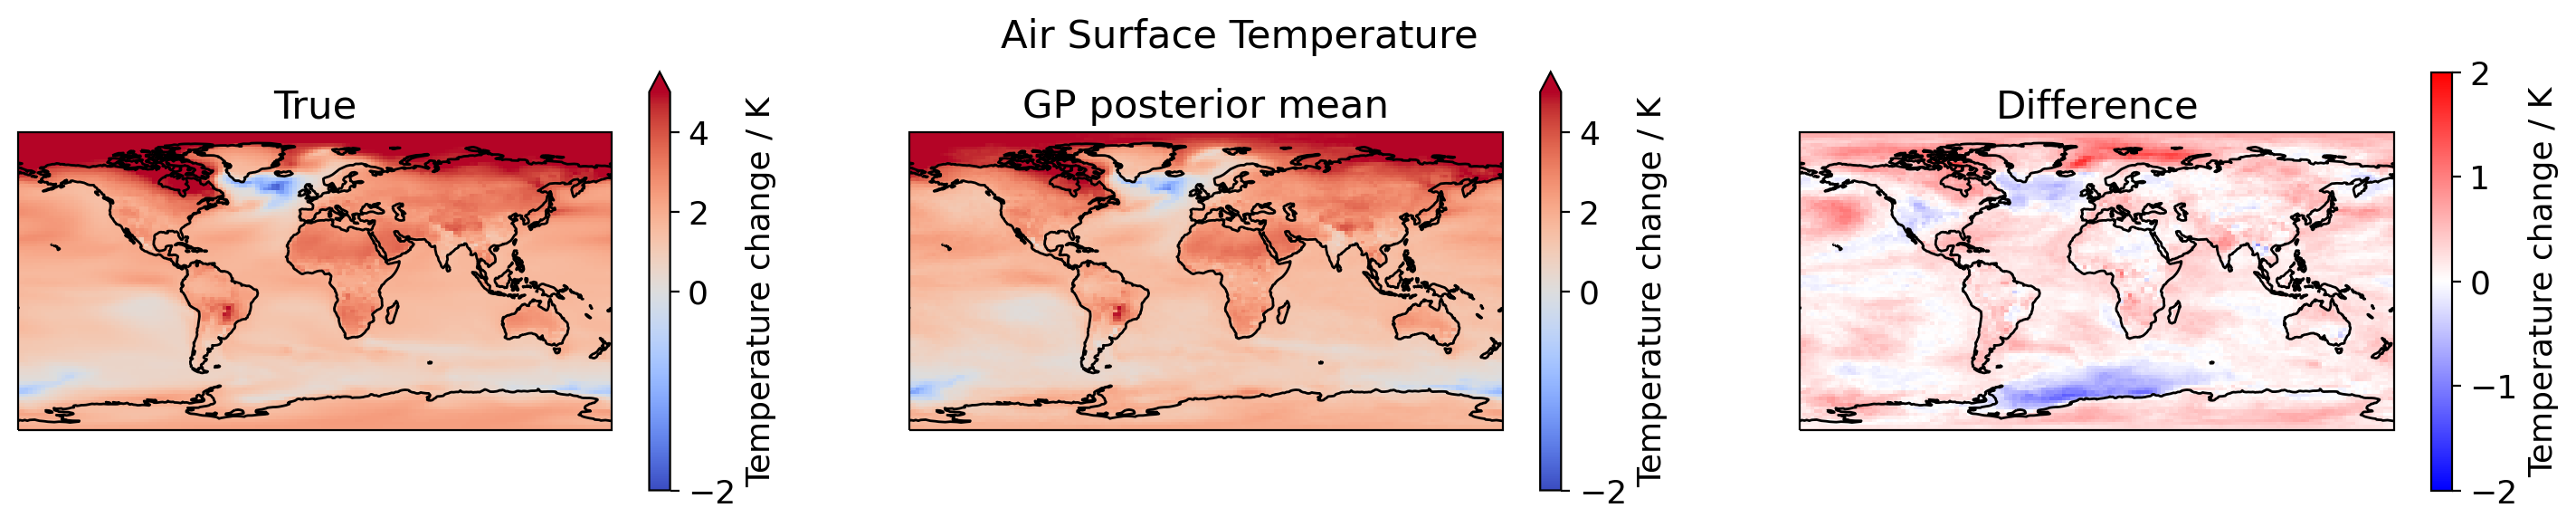

In [ ]:
import cartopy.crs as ccrs
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Air Surface Temperature')

# Test
plt.subplot(131, projection=proj)
y_test_xr.tas.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
y_test_pre.tas_mean.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = y_test_xr.tas - y_test_pre.tas_mean
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

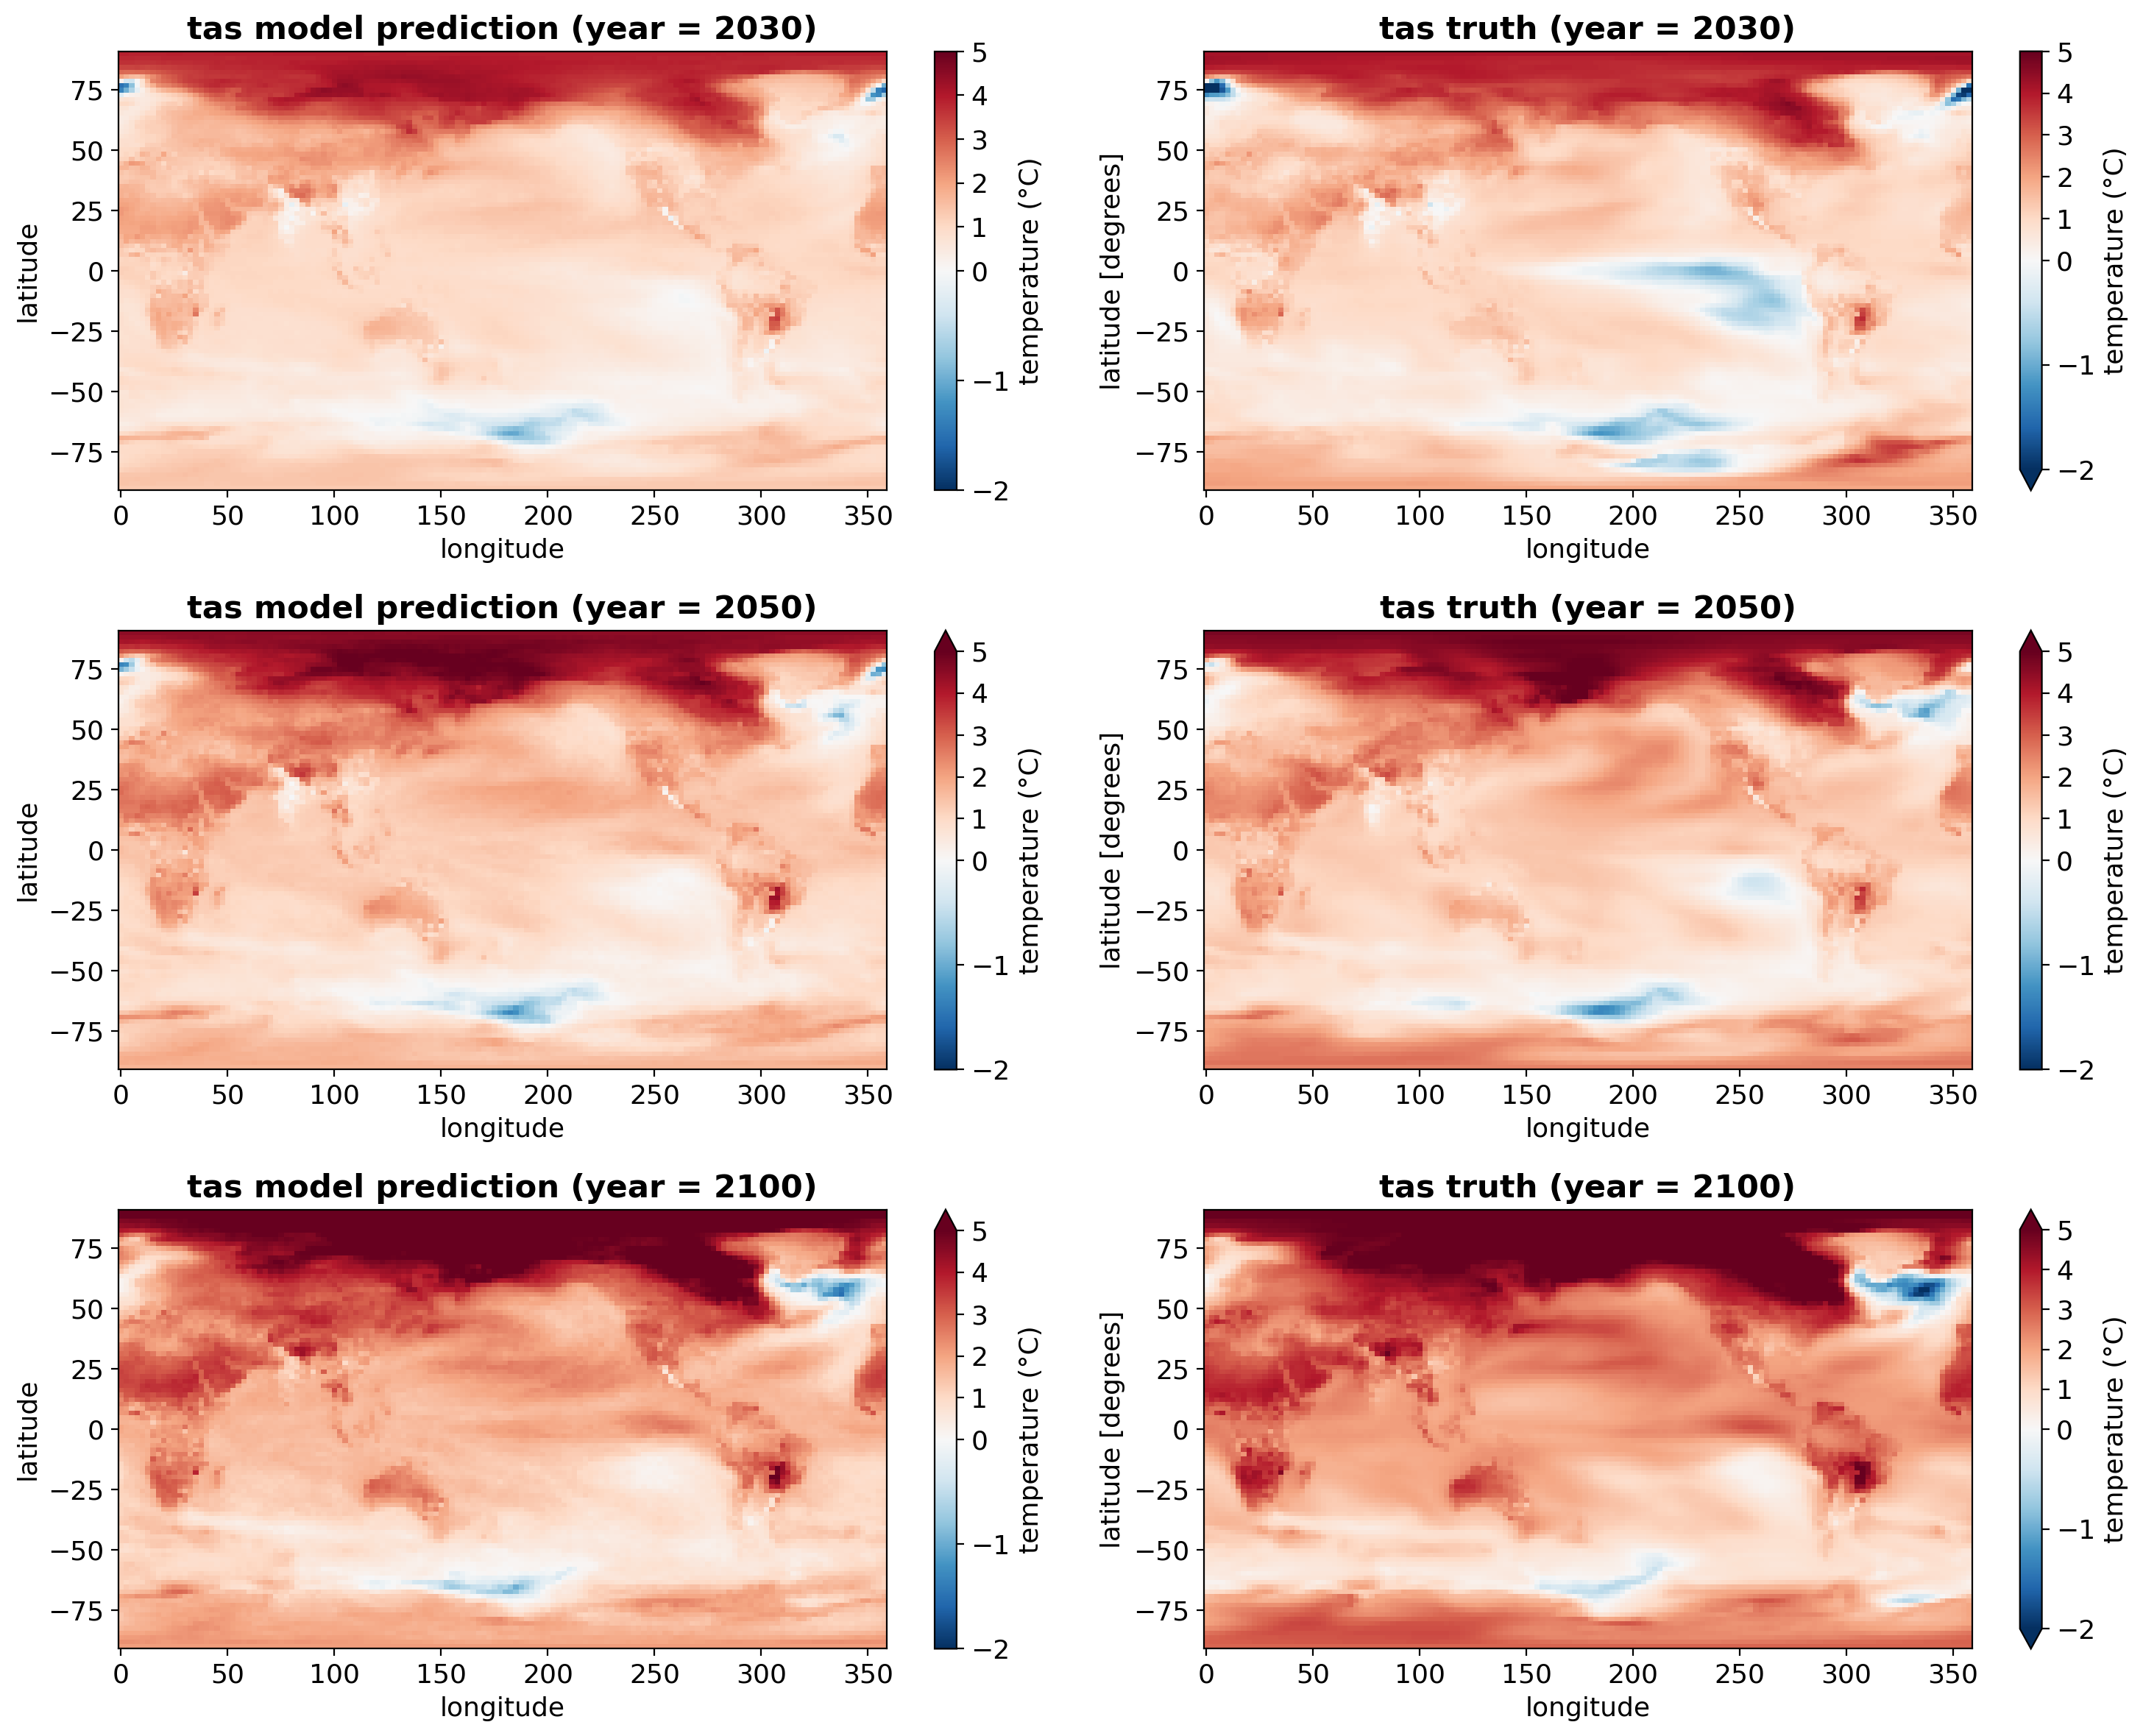

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()